In [19]:
! pip install gymnasium
! pip install gym


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import sys
import torch

# -------------------------------
# 1) src klasörünü path'e ekle
# -------------------------------
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# -------------------------------
# 2) RL Environment import
# -------------------------------
try:
    from src.env_rl import ProductionLineEnv
except ModuleNotFoundError as e:
    print("⚠ HATA: 'gymnasium' veya 'gym' kurulu olmayabilir.")
    print("→ Çözüm: pip install gymnasium")
    raise e


In [21]:
df = pd.read_csv("../data/simulated/line_data.csv")
df.head()


,time,step,hour,shift_id,normal_queue,priority_queue,wip_total,completed_jobs,defect_rate,defects,...,machine_A_speed,machine_B_speed,machine_C_speed,maintenance_A,maintenance_B,maintenance_C,demand_spike_flag,queue_length,lead_time,machine_status
0,0.0,0,0,3,7.0,0.0,7.0,5,0.082489,0,...,2.319144,1.780925,1.178936,0,0,0,0,7.0,1.4,1.0
1,1.0,1,0,3,3.0,0.0,3.0,5,0.082611,0,...,2.166149,1.562310,0.929916,0,0,0,0,3.0,0.6,1.0
2,2.0,2,0,3,0.0,0.0,0.0,3,0.082709,0,...,1.997636,1.812255,1.099372,0,0,0,0,0.0,0.0,1.0
3,3.0,3,0,3,0.0,0.0,0.0,2,0.082782,0,...,2.066750,1.783581,1.280313,0,0,0,0,0.0,0.0,1.0
4,4.0,4,0,3,0.0,0.0,0.0,1,0.082828,0,...,1.892805,1.543757,1.344203,0,0,0,0,0.0,0.0,1.0


In [22]:
import os

for root, dirs, files in os.walk("../models", topdown=True):
    print(root, files)


../models ['lstm_lead_time.pt', 'lstm_scaler.pkl']


In [31]:
import torch
import pickle
from src.lstm_torch import create_lstm_torch

# Modeli oluştur
lstm_model = create_lstm_torch()

# Ağırlıkları yükle
state_dict = torch.load("../models/lstm_lead_time.pt", map_location="cpu")
lstm_model.load_state_dict(state_dict)
lstm_model.eval()

# Scaler'ı yükle
with open("../models/lstm_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

print(" PyTorch LSTM modeli ve scaler yüklendi.")


 PyTorch LSTM modeli ve scaler yüklendi.


In [32]:
import torch
from src.lstm_torch import create_lstm_torch
import pickle
import os

# MODEL DOSYASI
model_path = "../models/lstm_lead_time.pt"
scaler_path = "../models/lstm_scaler.pkl"

# 1) Model dosyası mevcut mu kontrol et
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model dosyası bulunamadı: {model_path}")

# 2) Model yapısını oluştur (aynı parametrelerle)
model = create_lstm_torch()

# 3) Ağırlıkları yükle
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
model.eval()

# 4) Scaler'ı yükle
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)

print(" PyTorch LSTM modeli ve scaler başarıyla yüklendi.")


 PyTorch LSTM modeli ve scaler başarıyla yüklendi.


In [33]:
import numpy as np

def prepare_sequences(series, window=10):
    """
    1D numpy array için sliding window dizileri üretir.
    X.shape = (batch, window)
    y.shape = (batch,)
    """
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)


In [34]:
import torch

# lead_time serisini al
series = df["lead_time"].values.reshape(-1, 1)

# scaler ile tüm seriyi ölçekle
series_scaled = scaler.transform(series).flatten()

def lstm_predict_fn(t_index, window=10):
    """
    RL Environment her step'te t_index verir.
    Bu fonksiyon geçmiş 'window' kadar lead_time kullanıp
    PyTorch LSTM ile tahmin üretir.
    """

    # Geçmiş veri yoksa → gerçek değeri döndür
    if t_index < window:
        return float(df["lead_time"].iloc[t_index])

    # 1) Girdi dizisini hazırla
    seq = series_scaled[t_index-window:t_index]   # shape = (window,)
    seq = torch.tensor(seq, dtype=torch.float32).reshape(1, window, 1)

    # 2) Model ile tahmin
    lstm_model.eval()
    with torch.no_grad():
        pred_scaled = lstm_model(seq).item()

    # 3) Orijinal skala'ya döndür
    pred_unscaled = scaler.inverse_transform([[pred_scaled]])[0][0]

    return float(pred_unscaled)


In [35]:
print("Tahmin örneği:", lstm_predict_fn(50))


Tahmin örneği: 153.97172820568085


In [27]:
env = ProductionLineEnv(df, lstm_predict_fn)
state, info = env.reset()

state


array([7.        , 0.60995585, 1.        , 1.4       ], dtype=float32)

In [28]:
states = []
rewards = []
actions = []

state, _ = env.reset()

for i in range(10):
    action = env.action_space.sample()   # rastgele aksiyon
    next_state, reward, done, _, _ = env.step(action)

    states.append(next_state)
    rewards.append(reward)
    actions.append(action)

    if done:
        break

np.array(states).shape, rewards[:5], actions[:5]


((10, 4), [-1.1199999999999999, -0.6, -0.0, -0.0, -0.0], [2, 1, 1, 1, 1])

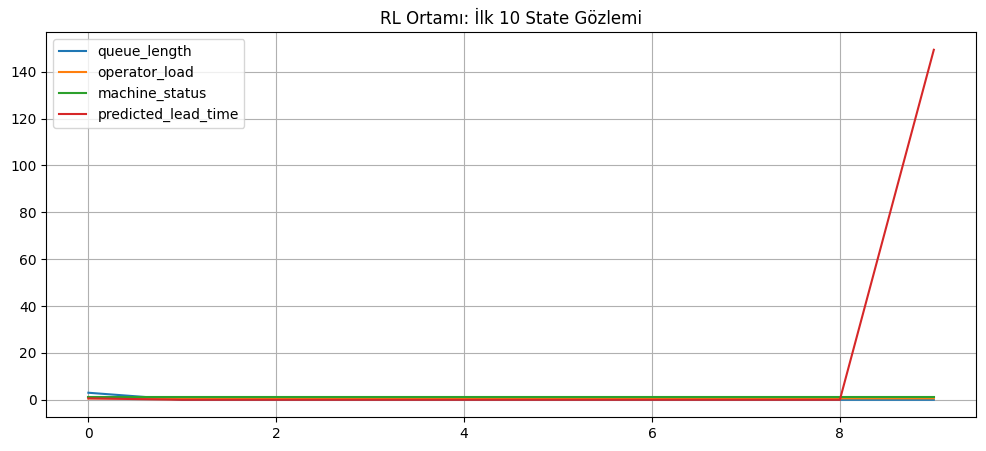

In [29]:
states_arr = np.array(states)

plt.figure(figsize=(12,5))
plt.plot(states_arr[:,0], label="queue_length")
plt.plot(states_arr[:,1], label="operator_load")
plt.plot(states_arr[:,2], label="machine_status")
plt.plot(states_arr[:,3], label="predicted_lead_time")
plt.title("RL Ortamı: İlk 10 State Gözlemi")
plt.legend()
plt.grid()
plt.show()


In [30]:
print("""
RL Ortamı Başarıyla Oluşturuldu:
- Gözlem uzayı: queue_length, operator_load, machine_status, predicted_lead_time
- Aksiyon uzayı: 0=hız azalt, 1=sabit, 2=hız artır
- LSTM modeli lead_time için gerçek zamanlı tahmin sağlıyor
""")



RL Ortamı Başarıyla Oluşturuldu:
- Gözlem uzayı: queue_length, operator_load, machine_status, predicted_lead_time
- Aksiyon uzayı: 0=hız azalt, 1=sabit, 2=hız artır
- LSTM modeli lead_time için gerçek zamanlı tahmin sağlıyor

